In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
p0 = 0
t = np.arange(60)
w0 = 5
a = 5

Equation 1 in K smith(2016). 
$$ \phi(t) = \phi_{0} + \omega_{0}t + \frac{1}{2}\alpha t^2$$

In [6]:
def pulse_phase(p0,t,w0,a):
    '''
    This function calculates and returns pulse phase at any given time 't' when acceleration 'a', intial 
    phase 'p0' and angular frequency 'w0' is known.
    '''
    phase = p0 + w0*t + 0.5*a*t**2
    return phase

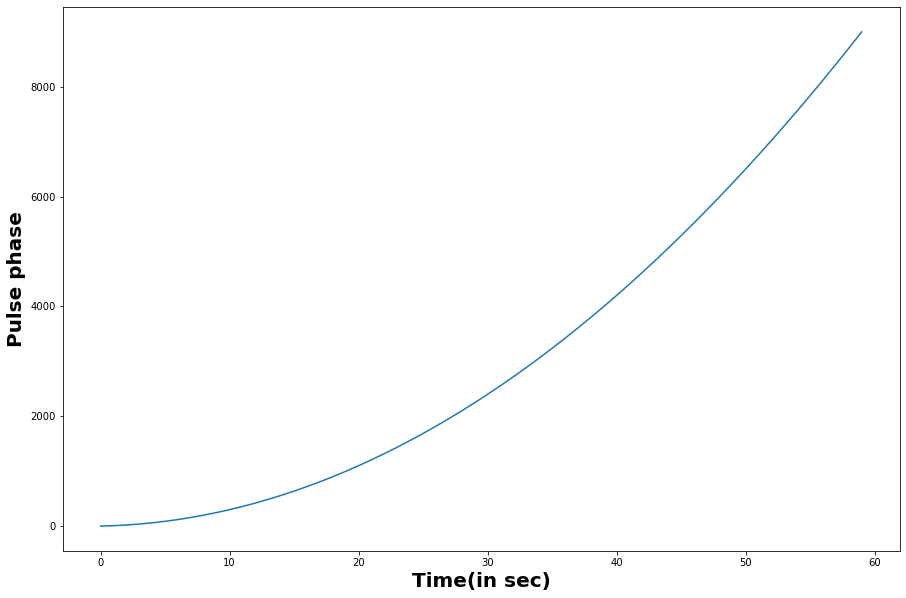

In [24]:
fig, pulse = plt.subplots(figsize = (15,10))
x1 = t
y1 = pulse_phase(p0,t,w0,a)
pulse.plot(x1,y1)
pulse.set_xlabel('Time(in sec)', fontsize = 20, weight = 'bold')
pulse.set_ylabel('Pulse phase', fontsize = 20, weight = 'bold')
plt.show()

Von Mises profile can be obtained from the euqtion(Eqn 2, K Smith)

$$ \rho(\phi) = e^{-2\kappa(sin^2(\phi/2))}$$

where $$\kappa = \frac{log(2)}{2sin^2{(\pi D/2)}}$$

In [13]:
phase_angle = pulse_phase(p0,t,w0,a)

def von_mises_profile(angle,duty):
    '''
    This function calculates von_mises profile based on duty cycle obtained from previous kappa function.
    For the vlue of pulse_phase it makes a call from pulse_phase function defined above
    '''
    k = (np.log(2))/(2*(np.sin((np.pi*duty)/2))**2)
    
    y = np.exp(-2*k*(np.sin(phase_angle/2))**2)
    
    return y

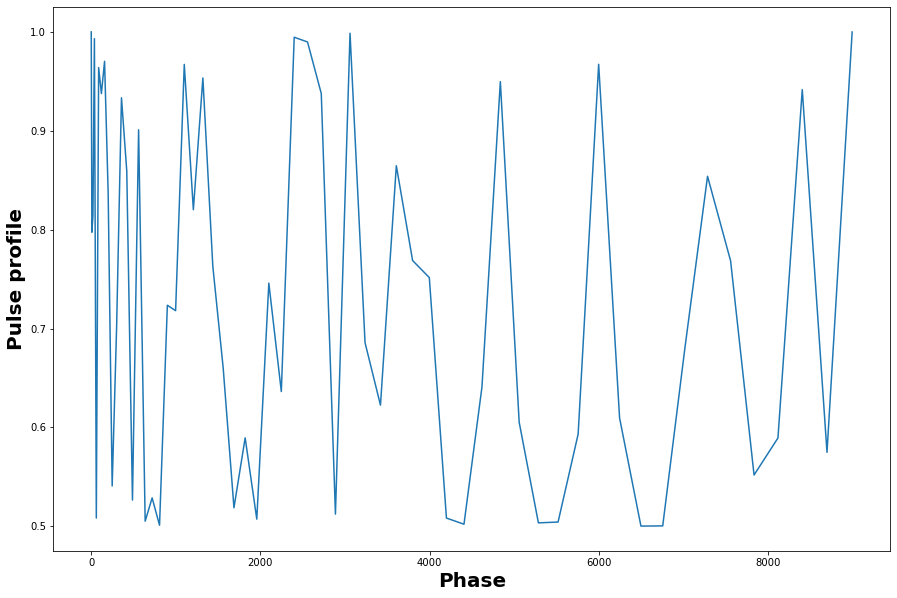

In [28]:
fig, von_mises = plt.subplots(figsize = (15,10))
x2 = phase_angle
y2 = von_mises_profile(x1, 5)
von_mises.plot(x2,y2)
von_mises.set_xlabel('Phase', fontsize = 20, weight = 'bold')
von_mises.set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
plt.show()